In [27]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

path = "./Measurement Data"

# 1. Dataset preparation

## Merge every trip dataset into a global one

In [28]:
files = Path(path).rglob("*.csv")

In [29]:
def rename_columns(df):

    # New column names
    new_columns = {
        'Time [s]': 'time_s',
        'Velocity [km/h]': 'velocity_km_h',
        'Velocity [km/h]]]': 'velocity_km_h',
        'Elevation [m]': 'elevation_m',
        'Throttle [%]': 'throttle_percent',
        'Motor Torque [Nm]': 'motor_torque_nm',
        'Longitudinal Acceleration [m/s^2]': 'longitudinal_acceleration_m_s2',
        'Regenerative Braking Signal ': 'regenerative_braking_signal',
        'Battery Voltage [V]': 'battery_voltage_v',
        'Battery Current [A]': 'battery_current_a',
        'Battery Temperature [°C]': 'battery_temperature_c',
        'max. Battery Temperature [°C]': 'max_battery_temperature_c',
        'SoC [%]': 'soc_percent',
        'displayed SoC [%]': 'displayed_soc_percent',
        'min. SoC [%]': 'min_soc_percent',
        'max. SoC [%)': 'max_soc_percent',
        'Heating Power CAN [kW]': 'heating_power_can_kw',
        'Heating Power LIN [W]': 'heating_power_lin_w',
        'Requested Heating Power [W]': 'requested_heating_power_w',
        'AirCon Power [kW]': 'aircon_power_kw',
        'Heater Signal': 'heater_signal',
        'Heater Voltage [V]': 'heater_voltage_v',
        'Heater Current [A]': 'heater_current_a',
        'Ambient Temperature [°C]': 'ambient_temperature_c',
        'Coolant Temperature Heatercore [°C]': 'coolant_temperature_heatercore_c',
        'Requested Coolant Temperature [°C]': 'requested_coolant_temperature_c',
        'Coolant Temperature Inlet [°C]': 'coolant_temperature_inlet_c',
        'Heat Exchanger Temperature [°C]': 'heat_exchanger_temperature_c',
        'Cabin Temperature Sensor [°C]': 'cabin_temperature_sensor_c',
        'Ambient Temperature Sensor [°C]': 'ambient_temperature_sensor_c',
        'Coolant Volume Flow +500 [l/h]': 'coolant_volume_flow_plus_500_l_h',
        'Temperature Coolant Heater Inlet [°C]': 'temperature_coolant_heater_inlet_c',
        'Temperature Coolant Heater Outlet [°C]': 'temperature_coolant_heater_outlet_c',
        'Temperature Heat Exchanger Outlet [°C]': 'temperature_heat_exchanger_outlet_c',
        'Temperature Defrost lateral left [°C]': 'temperature_defrost_lateral_left_c',
        'Temperature Defrost lateral right [°C]': 'temperature_defrost_lateral_right_c',
        'Temperature Defrost central [°C]': 'temperature_defrost_central_c',
        'Temperature Defrost central left [°C]': 'temperature_defrost_central_left_c',
        'Temperature Defrost central right [°C]': 'temperature_defrost_central_right_c',
        'Temperature Footweel Driver [°C]': 'temperature_footweel_driver_c',
        'Temperature Footweel Co-Driver [°C]': 'temperature_footweel_co_driver_c',
        'Temperature Feetvent Co-Driver [°C]': 'temperature_feetvent_co_driver_c',
        'Temperature Feetvent Driver [°C]': 'temperature_feetvent_driver_c',
        'Temperature Head Co-Driver [°C]': 'temperature_head_co_driver_c',
        'Temperature Head Driver [°C]': 'temperature_head_driver_c',
        'Temperature Vent right [°C] ': 'temperature_vent_right_c_1',
        'Temperature Vent right [°C]': 'temperature_vent_right_c_2',
        'Temperature Vent central right [°C]': 'temperature_vent_central_right_c',
        'Temperature Vent central left [°C]': 'temperature_vent_central_left_c',
    }

    # Rename columns
    df.rename(columns=new_columns, inplace=True)

    # Drop useless columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    return df

In [30]:
dfs = list()

# Process each file
for file in files:
    print(file, " Importing...")
    data = pd.read_csv(file, encoding='ISO-8859-13', delimiter=';')
    data['trip_file_name'] = file.stem
    data = rename_columns(data)
    dfs.append(data)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

Measurement Data/TripA32.csv  Importing...
Measurement Data/TripB02.csv  Importing...
Measurement Data/TripA10.csv  Importing...
Measurement Data/TripA23.csv  Importing...
Measurement Data/TripB24.csv  Importing...
Measurement Data/TripB38.csv  Importing...
Measurement Data/TripB12.csv  Importing...
Measurement Data/TripB21.csv  Importing...
Measurement Data/TripB19.csv  Importing...
Measurement Data/TripA12.csv  Importing...
Measurement Data/TripB20.csv  Importing...
Measurement Data/TripA17.csv  Importing...
Measurement Data/TripA13.csv  Importing...
Measurement Data/TripA27.csv  Importing...
Measurement Data/TripA29.csv  Importing...
Measurement Data/TripB32.csv  Importing...
Measurement Data/TripB13.csv  Importing...
Measurement Data/TripB09.csv  Importing...
Measurement Data/TripB10.csv  Importing...
Measurement Data/TripB26.csv  Importing...
Measurement Data/TripB11.csv  Importing...
Measurement Data/TripB17.csv  Importing...
Measurement Data/TripA31.csv  Importing...
Measurement

In [31]:
# Enregistrer le fichier
df.to_csv('01_Mergerd.csv', index=False)

## Extracting data from the travel_name column
The travel_name column contains informations about the trip. We will extract the following information:
  - The trip season (A: Summer, B: Winter)
  - The trip identification number

In [32]:
df['trip_season'] = np.where(df['trip_file_name'].str.contains('A'), 'summer', 'winter')

# print(df['trip_season'].value_counts())

df['trip_id'] = df['trip_file_name'].str.removeprefix('Trip')

# print(df['trip_id'].value_counts())

## Handling missing data
> The measurement data are divided into two categories. Category A was recorded in summer and does not contain all measured data due to trouble with the measurement system.  Category B was recorded in winter and is consistent. 

In [33]:
print(df.isnull().sum().sort_values()[df.isnull().sum() > 0])

requested_coolant_temperature_c         19829
soc_percent                             30793
min_soc_percent                         30793
displayed_soc_percent                   30794
max_soc_percent                         30794
coolant_temperature_inlet_c            310587
heater_current_a                       310587
heater_voltage_v                       310587
heating_power_lin_w                    310587
coolant_temperature_heatercore_c       310587
temperature_vent_right_c_2             472340
temperature_vent_central_left_c        472340
temperature_vent_central_right_c       472340
temperature_vent_right_c_1             472340
temperature_head_driver_c              472340
temperature_head_co_driver_c           472340
temperature_feetvent_driver_c          472340
temperature_feetvent_co_driver_c       472340
temperature_footweel_co_driver_c       472340
temperature_defrost_central_right_c    472340
temperature_defrost_central_left_c     472340
temperature_defrost_central_c     

We can choose to:
  - Drop columns with missing data
  - Drop rows with missing data
  - Fill missing data with statistical methods (mean, median, mode, etc.)

Drop rows is not a good idea because we will lose a lot of data (all the summer data).

The missing data for the "summer" trips are mostly precisions about temperatures for the cabin. We can fill them with the global values or forget them and focus on the global cabin data.

---
### State of Charge (SoC) missing data
**For the folowing columns :**
- soc_percent
- min_soc_percent
- displayed_soc_percent
- max_soc_percent

The missing value occurs only for the first and last occurence of each trip (start and end of the trip). We can fill them with the next (for the first occurence) or previous (for the last occurence) value because we can assume that the SoC (State of Charge) doesn't change during the first and last 0.1s of the trip.

In [34]:
# For each trip, fill missing values (for theses columns) with the previous (if exists) or next (if exists) value.

df['soc_percent'] = df.groupby('trip_id')['soc_percent'].ffill().bfill()
df['min_soc_percent'] = df.groupby('trip_id')['min_soc_percent'].ffill().bfill()
df['displayed_soc_percent'] = df.groupby('trip_id')['displayed_soc_percent'].ffill().bfill()
df['max_soc_percent'] = df.groupby('trip_id')['max_soc_percent'].ffill().bfill()

print(df.isnull().sum().sort_values()[df.isnull().sum() > 0])

requested_coolant_temperature_c         19829
coolant_temperature_inlet_c            310587
heater_current_a                       310587
heater_voltage_v                       310587
heating_power_lin_w                    310587
coolant_temperature_heatercore_c       310587
temperature_vent_right_c_2             472340
temperature_vent_central_left_c        472340
temperature_vent_central_right_c       472340
temperature_vent_right_c_1             472340
temperature_head_driver_c              472340
temperature_head_co_driver_c           472340
temperature_feetvent_driver_c          472340
temperature_feetvent_co_driver_c       472340
temperature_footweel_co_driver_c       472340
temperature_defrost_central_right_c    472340
temperature_defrost_central_left_c     472340
temperature_defrost_central_c          472340
temperature_defrost_lateral_right_c    472340
temperature_defrost_lateral_left_c     472340
temperature_heat_exchanger_outlet_c    472340
temperature_coolant_heater_outlet_

----
### Cabin temperature missing data
For the cabin temperatures, we choose to drop the columns because, all these precisions are not relevant for the analysis of the trips. We will focus on the global cabin temperature.

In [35]:
columns_to_drop = [
    'temperature_vent_right_c_1',
    'temperature_vent_right_c_2',
    'temperature_vent_central_left_c',
    'temperature_vent_central_right_c',
    'temperature_head_driver_c',
    'temperature_head_co_driver_c',
    'temperature_feetvent_driver_c',
    'temperature_feetvent_co_driver_c',
    'temperature_footweel_driver_c',
    'temperature_footweel_co_driver_c',
    'temperature_defrost_central_right_c',
    'temperature_defrost_central_left_c',
    'temperature_defrost_central_c',
    'temperature_defrost_lateral_right_c',
    'temperature_defrost_lateral_left_c'
]

df.drop(columns=columns_to_drop, inplace=True)

print(df.isnull().sum().sort_values()[df.isnull().sum() > 0])

requested_coolant_temperature_c         19829
heater_voltage_v                       310587
heater_current_a                       310587
coolant_temperature_heatercore_c       310587
coolant_temperature_inlet_c            310587
heating_power_lin_w                    310587
ambient_temperature_sensor_c           472340
temperature_coolant_heater_inlet_c     472340
temperature_coolant_heater_outlet_c    472340
temperature_heat_exchanger_outlet_c    472340
coolant_volume_flow_plus_500_l_h       496034
dtype: int64


----
### Heating/A.C. missing data
For the heater data (current, voltage), we choose to use the mean value for the voltage, and calculate the current with the formula: P = U * I, where P is the power ("heating_power_can_kw"), U the voltage and I the current. We can calculate the current with the formula: I = P / U.

In [36]:
# fill missing values with the mean of the column, for the same season
df['heater_voltage_v'] = df['heater_voltage_v'].fillna(df.groupby('trip_season')['heater_voltage_v'].transform('mean'))

# use I=P/U to calculate the missing values of the heater_current_a
df['heater_current_a'] = df['heater_current_a'].fillna((df['heating_power_can_kw'] * 1000) / df['heater_voltage_v'])

print(df.isnull().sum().sort_values()[df.isnull().sum() > 0])

requested_coolant_temperature_c         19829
coolant_temperature_heatercore_c       310587
coolant_temperature_inlet_c            310587
heating_power_lin_w                    310587
ambient_temperature_sensor_c           472340
temperature_coolant_heater_inlet_c     472340
temperature_coolant_heater_outlet_c    472340
temperature_heat_exchanger_outlet_c    472340
coolant_volume_flow_plus_500_l_h       496034
dtype: int64


For the **heating_power_lin_w**, we already have the heating_power_can_kW that is consistent. We can drop the heating_power_lin_w column.

In [37]:
df.drop(columns=["heating_power_lin_w"], inplace=True)

For the **requested_coolant_temperature**, we can't find correlations with other columns, and don't vary during the trips (always at 0, 85 or 215). We think that this column is not relevant for the analysis of the trips. We will drop it.

In [38]:
df.drop(columns=["requested_coolant_temperature_c"], inplace=True)

For **ambiant_temperature_sensor_c**, a column named `ambient_temperature_c` and it's consistent. We can drop the `ambiant_temperature_sensor_c` column.

For **coolant_temperature_heatercore_c**, **coolant_temperature_inlet_c**, **temperature_coolant_heater_inlet_c**, **temperature_coolant_heater_outlet_c**, **temperature_heat_exchanger_outlet_c**, **coolant_volume_flow_plus_500_l_h**, we can drop them because we have the `heat_exchanger_temperature_c` column that is consistent and sufficient for our analysis of the trips. We will rename it to `coolant_temperature_c`.

In [39]:
columns_to_drop = [
    "ambient_temperature_sensor_c",
    "coolant_temperature_heatercore_c",
    "coolant_temperature_inlet_c",
    "temperature_coolant_heater_inlet_c",
    "temperature_coolant_heater_outlet_c",
    "temperature_heat_exchanger_outlet_c",
    "coolant_volume_flow_plus_500_l_h"
]

df.drop(columns=columns_to_drop, inplace=True)

In [40]:
# Enregistrer le fichier
df.to_csv('02_Cleaned.csv', index=False)

# 2. Exploratory data analysis

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df.describe()

,time_s,velocity_km_h,elevation_m,throttle_percent,motor_torque_nm,longitudinal_acceleration_m_s2,regenerative_braking_signal,battery_voltage_v,battery_current_a,battery_temperature_c,...,max_soc_percent,heating_power_can_kw,requested_heating_power_w,aircon_power_kw,heater_signal,heater_voltage_v,heater_current_a,ambient_temperature_c,heat_exchanger_temperature_c,cabin_temperature_sensor_c
count,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,...,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06
mean,1.030379e+03,4.464870e+01,5.322089e+02,2.807981e+01,1.076890e+01,-4.172878e-03,5.211902e-02,3.763793e+02,-1.730302e+01,1.541675e+01,...,8.909071e+01,1.220611e+00,1.183415e+03,1.649602e-01,9.245136e-01,3.598452e+02,3.368359e+00,1.306448e+01,2.897248e+01,2.395951e+01
std,8.948726e+02,3.535815e+01,4.528273e+01,1.875741e+01,3.480368e+01,6.324723e-01,2.219785e-01,1.185949e+01,4.443506e+01,7.430944e+00,...,6.328844e-01,1.763342e+00,1.783291e+03,3.675939e-01,2.641747e-01,8.011016e+01,4.753991e+00,9.622983e+00,1.588218e+01,4.852177e+00
min,0.000000e+00,0.000000e+00,4.370000e+02,0.000000e+00,-8.790000e+01,-9.030000e+00,0.000000e+00,3.018000e+02,-4.043800e+02,-1.000000e+00,...,8.800000e+01,0.000000e+00,0.000000e+00,-1.700000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-3.500000e+00,5.000000e+00,1.000000e+01
25%,3.915000e+02,1.437000e+01,4.871300e+02,1.033000e+01,0.000000e+00,-2.400000e-01,0.000000e+00,3.691300e+02,-3.127000e+01,9.000000e+00,...,8.850000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.273234e+02,0.000000e+00,5.000000e+00,1.250000e+01,2.267120e+01
50%,8.121000e+02,4.092000e+01,5.309100e+02,3.324000e+01,6.500000e+00,-2.000000e-02,0.000000e+00,3.795100e+02,-1.146000e+01,1.400000e+01,...,8.900000e+01,9.600000e-01,8.800000e+02,0.000000e+00,1.000000e+00,3.690000e+02,2.500000e+00,9.500000e+00,3.450000e+01,2.417000e+01
75%,1.380900e+03,6.766000e+01,5.672600e+02,4.297499e+01,2.236000e+01,2.000000e-01,0.000000e+00,3.854000e+02,-1.690000e+00,2.100000e+01,...,8.950000e+01,1.480000e+00,1.424700e+03,2.000000e-01,1.000000e+00,3.821600e+02,4.000000e+00,2.150000e+01,4.150000e+01,2.584000e+01
max,5.610100e+03,1.522600e+02,6.649900e+02,1.352500e+02,2.495000e+02,4.460000e+00,1.000000e+00,3.947585e+02,1.444900e+02,3.200000e+01,...,9.000000e+01,4.004000e+01,3.852775e+04,3.320000e+00,1.000000e+00,1.022960e+03,1.000900e+02,3.350000e+01,6.505000e+01,3.984130e+01


Histogramme

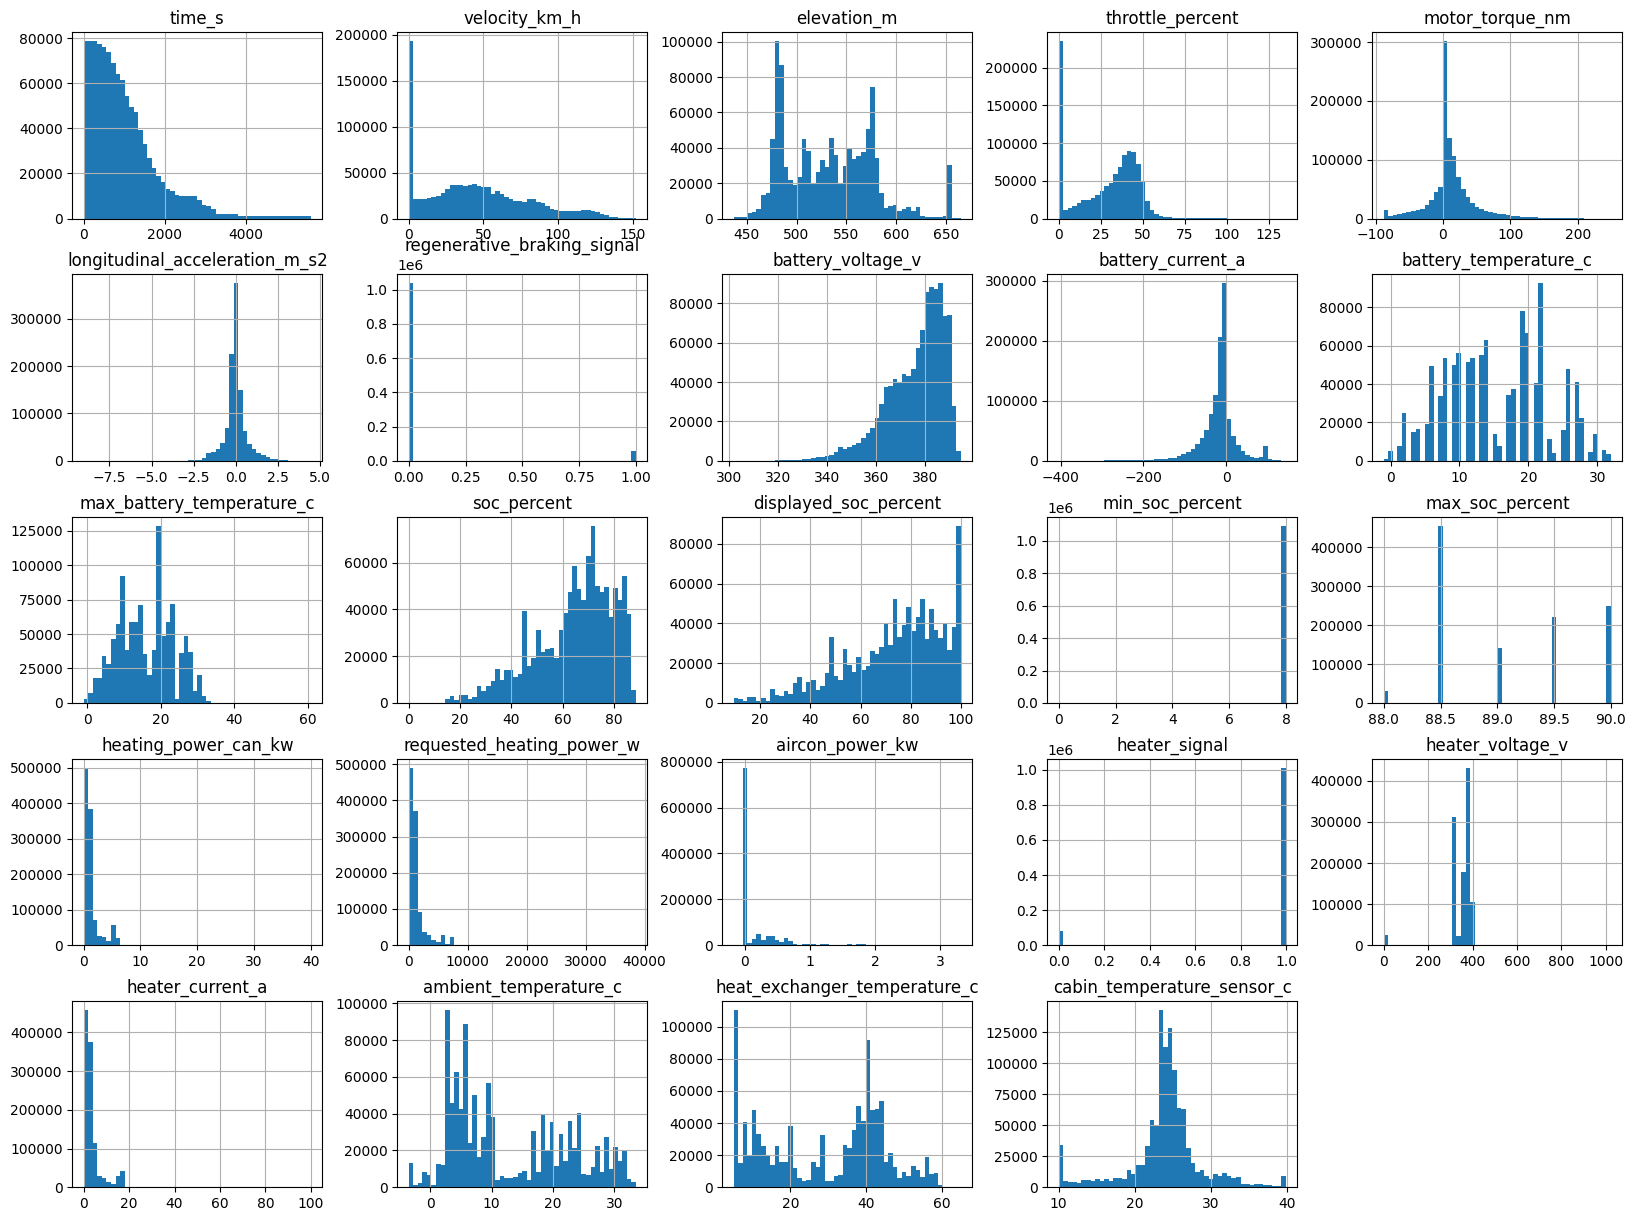

In [43]:
# Histogramme pour visualiser la distribution des variables numériques
df.hist(bins=50, figsize=(20,15))
plt.show()

Matrice de corrélation

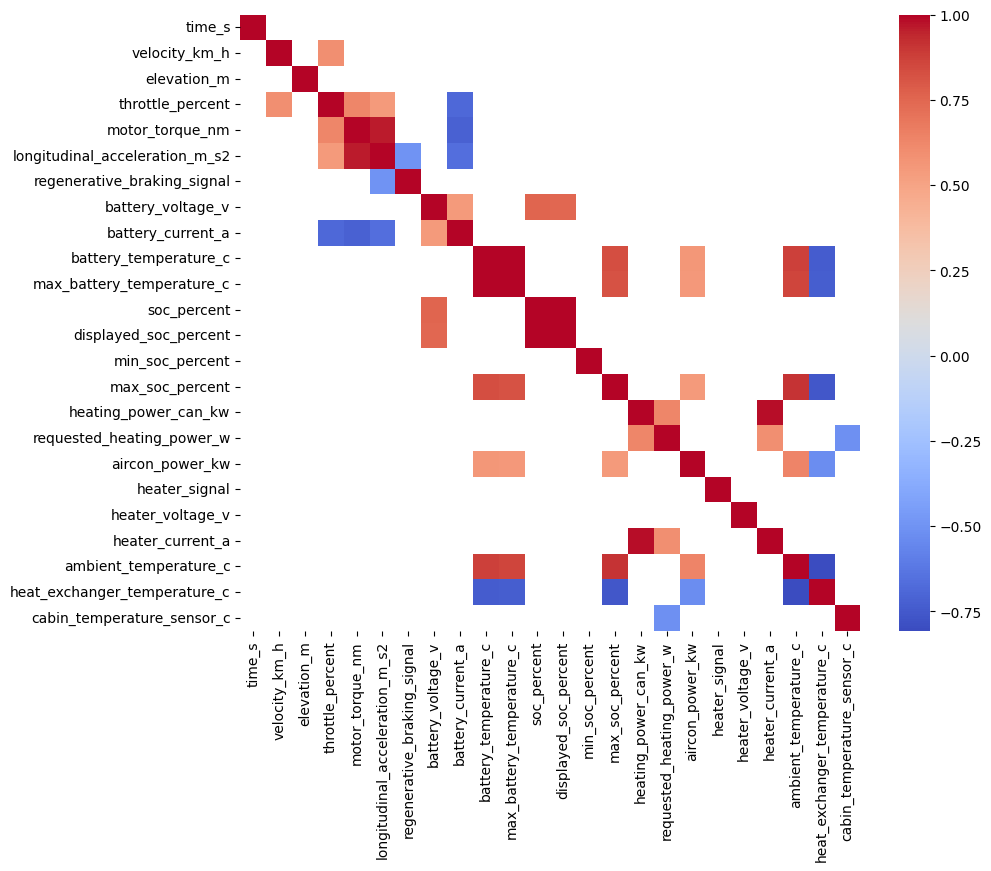

In [44]:
num_df = df.select_dtypes(include=[np.number])

corr = num_df.corr()

mask = np.abs(corr) < 0.5

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask = mask, annot=False, cmap='coolwarm')
plt.show()

### Analyse approfondie des corrélations fortes

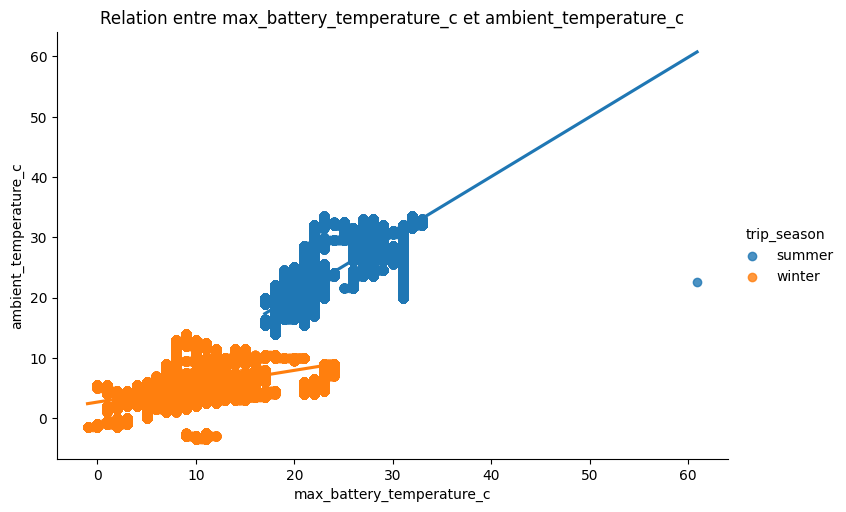

In [45]:
df.columns = df.columns.str.strip()

strong_correlations = [
    ('max_battery_temperature_c', 'ambient_temperature_c'),
]

for x_var, y_var in strong_correlations:
    if x_var in df.columns and y_var in df.columns:
        sns.lmplot(x=x_var, y=y_var, data=df, aspect=1.5, hue='trip_season')
        plt.title(f'Relation entre {x_var} et {y_var}')
        plt.xlabel(x_var)
        plt.ylabel(y_var)
    else:
        print(f"Une des variables n'est pas trouvée dans le DataFrame : '{x_var}' ou '{y_var}'")
plt.show()

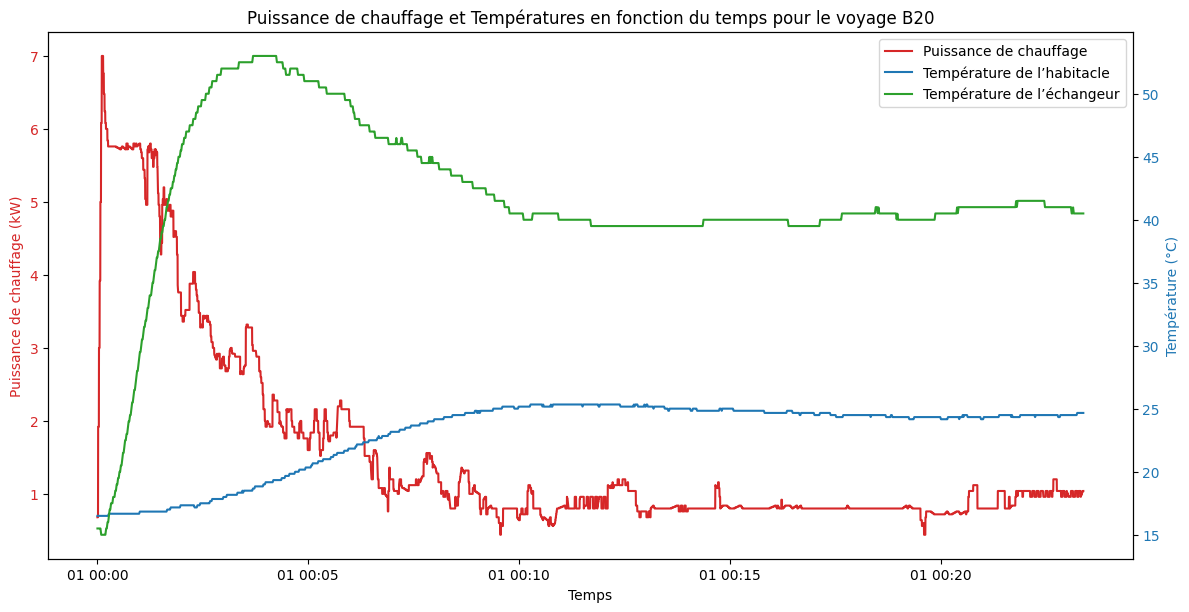

In [46]:
# Création d'une copie explicite pour éviter SettingWithCopyWarning
df_b20 = df[df['trip_id'] == 'B20'].copy()

# Convertir 'time_s' en datetime
df_b20['time_s'] = pd.to_datetime(df_b20['time_s'], unit='s')


# Créer un graphique avec deux axes y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Configurer le premier axe (ax1) pour la puissance de chauffage
color = 'tab:red'
ax1.set_xlabel('Temps')
ax1.set_ylabel('Puissance de chauffage (kW)', color=color)
ax1.plot(df_b20['time_s'], df_b20['heating_power_can_kw'], color=color, label='Puissance de chauffage')
ax1.tick_params(axis='y', labelcolor=color)

# Configurer un deuxième axe (ax2) pour les températures
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Température (°C)', color=color)
# Tracer la température de l'habitacle
ax2.plot(df_b20['time_s'], df_b20['cabin_temperature_sensor_c'], color=color, label='Température de l’habitacle')
# Tracer la température de l'échangeur de chaleur
ax2.plot(df_b20['time_s'], df_b20['heat_exchanger_temperature_c'], color='tab:green', label='Température de l’échangeur')
ax2.tick_params(axis='y', labelcolor=color)

# Ajouter une légende
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Titre et format
fig.tight_layout()
plt.title('Puissance de chauffage et Températures en fonction du temps pour le voyage B20')
plt.show()

##### Puissance de chauffage (en rouge) :
Cette courbe montre des fluctuations importantes au début de la période observée, suivies d'une stabilisation à une valeur inférieure. On peut interpréter ces fluctuations comme le système de chauffage s'ajustant à un état stable ou répondant à un besoin de chauffage qui change avec le temps.

##### Température de l'habitacle (en bleu) :
Cette courbe semble relativement stable sur toute la période, avec de légères variations. Cela suggère que la température à l'intérieur de l'habitacle reste assez constante, ce qui peut indiquer une bonne régulation du système de chauffage ou un équilibre entre les gains et les pertes de chaleur.

##### Température de l'échangeur de chaleur (en vert) :
Cette variable présente une augmentation suivie d'une stabilisation, ce qui pourrait indiquer que l'échangeur de chaleur atteint et maintient une température de fonctionnement optimale après une période initiale de chauffage.

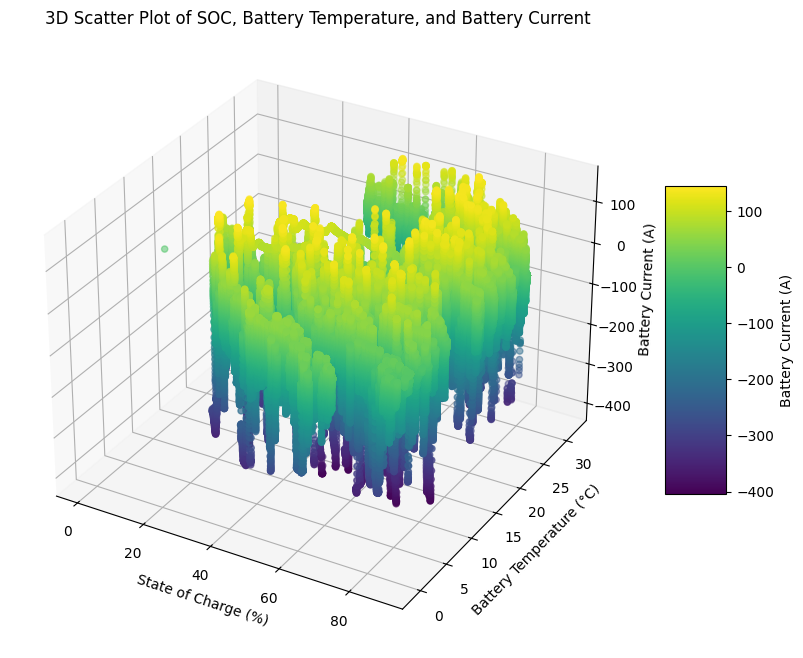

In [47]:
# Création de la figure et de l'axe 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Axes pour le graphique
X = df['soc_percent']              # État de charge de la batterie en pourcentage
Y = df['battery_temperature_c']    # Température de la batterie en °C
Z = df['battery_current_a']        # Courant maximal de récupération en A

# Tracer un scatter plot 3D
scatter = ax.scatter(X, Y, Z, c=Z, cmap='viridis', marker='o')

# Création de la colorbar
cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('Battery Current (A)')

# Etiquettes des axes
ax.set_xlabel('State of Charge (%)')
ax.set_ylabel('Battery Temperature (°C)')
ax.set_zlabel('Battery Current (A)')

# Titre
ax.set_title('3D Scatter Plot of SOC, Battery Temperature, and Battery Current')

# Afficher le graphique
plt.show()

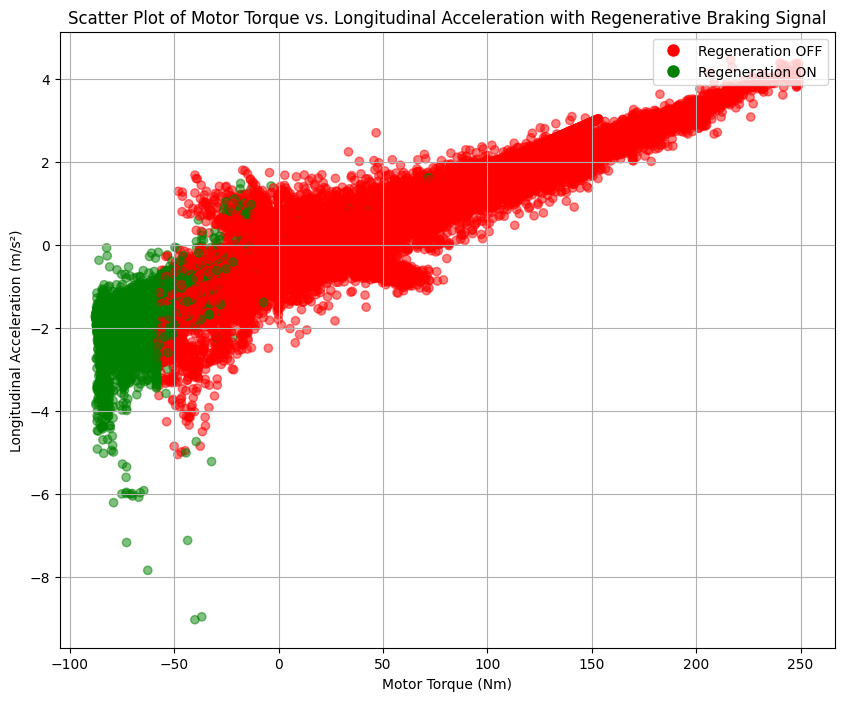

In [48]:
# Création du scatter plot
plt.figure(figsize=(10, 8))

# Utiliser 'regenerative_braking_signal' pour la couleur : 0 pour rouge et 1 pour vert
colors = ['red' if val == 0 else 'green' for val in df['regenerative_braking_signal']]

# Scatter plot pour 'motor_torque_nm' contre 'longitudinal_acceleration_m_s2'
plt.scatter(x=df['motor_torque_nm'], y=df['longitudinal_acceleration_m_s2'], c=colors, alpha=0.5)

# Etiquettes des axes et titre
plt.xlabel('Motor Torque (Nm)')
plt.ylabel('Longitudinal Acceleration (m/s²)')
plt.title('Scatter Plot of Motor Torque vs. Longitudinal Acceleration with Regenerative Braking Signal')

# Légende personnalisée
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Regeneration OFF', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='Regeneration ON', markerfacecolor='green', markersize=10)],
           loc='upper right')

# Afficher le graphique
plt.grid(True)
plt.show()

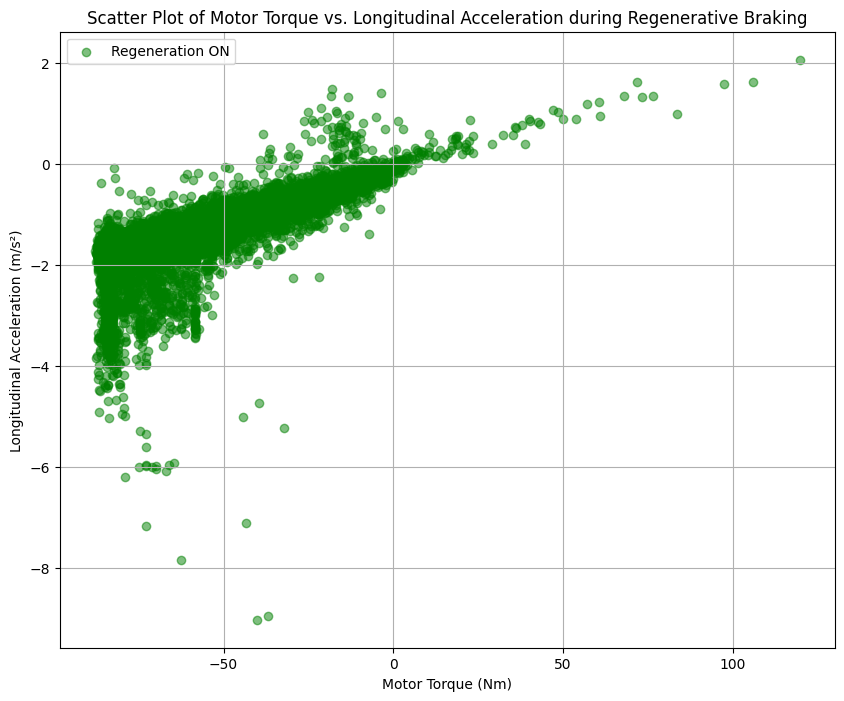

In [49]:
# Filtrer pour n'inclure que les données de décélération
df_deceleration = df[df['regenerative_braking_signal'] == 1]

# Création du scatter plot
plt.figure(figsize=(10, 8))

# Scatter plot pour 'motor_torque_nm' contre 'longitudinal_acceleration_m_s2' pendant la décélération
plt.scatter(x=df_deceleration['motor_torque_nm'], y=df_deceleration['longitudinal_acceleration_m_s2'], color='green', alpha=0.5)

# Etiquettes des axes et titre
plt.xlabel('Motor Torque (Nm)')
plt.ylabel('Longitudinal Acceleration (m/s²)')
plt.title('Scatter Plot of Motor Torque vs. Longitudinal Acceleration during Regenerative Braking')

# Légende
plt.legend(['Regeneration ON'])

# Afficher le graphique
plt.grid(True)
plt.show()

# 3. Data manipulation

In [50]:
grouped_season = df.groupby('trip_season')

grouped_season.agg({
    'trip_id': 'nunique',  # Nombre de trajets
    'velocity_km_h': ['mean', 'max', 'min'],  # Vitesse moyenne, maximale et minimale
    'throttle_percent': 'mean',  # Moyenne de l'angle de papillon des gaz
    'battery_temperature_c': 'mean',  # Température moyenne de la batterie
    'heating_power_can_kw': 'sum',  # Somme de la puissance de chauffage provenant du CAN
    'aircon_power_kw': 'sum',  # Somme de la puissance de climatisation
    'requested_heating_power_w': 'sum',  # Somme de la puissance de chauffage demandée
    'ambient_temperature_c': 'mean',  # Température ambiante moyenne
    'cabin_temperature_sensor_c': 'mean'  # Température moyenne du capteur de cabine
})

trip_id velocity_km_h              elevation_m throttle_percent  \
            nunique          mean     max  min        mean             mean   
trip_season                                                                   
summer           32     43.272358  151.59  0.0  556.289749        29.079288   
winter           38     45.675208  152.26  0.0  514.248835        27.334374   

            battery_temperature_c soc_percent heating_power_can_kw  \
                             mean        mean                  sum   
trip_season                                                          
summer                  22.356780   72.899698         3.250884e+05   
winter                  10.240706   58.493087         1.011228e+06   

            aircon_power_kw requested_heating_power_w heater_signal  \
                        sum                       sum          mean   
trip_season                                                           
summer         178197.29876              2.526753e+08      0.823302   
winter           2400.00581              1.042919e+09      1.000000   

            ambient_temperature_c cabin_temperature_sensor_c  
                             mean                       mean  
trip_season                                                   
summer                  23.176838                  26.363962  
winter                   5.522425                  22.166205

In [51]:
high_speed_values = df[df['velocity_km_h'] > 80].groupby('trip_season')

high_speed_values.agg({
    'velocity_km_h': ['mean', 'max', 'min'],  # Vitesse moyenne, maximale et minimale
    'battery_current_a': 'mean',  # Moyenne du courant de la batterie
    'motor_torque_nm': 'mean',  # Moyenne du couple moteur
    'heating_power_can_kw': 'sum',  # Somme de la puissance de chauffage provenant du CAN
    'aircon_power_kw': 'sum',  # Somme de la puissance de climatisation
    'ambient_temperature_c': 'mean',  # Température ambiante moyenne
    'cabin_temperature_sensor_c': 'mean'  # Température moyenne du capteur de cabine
})

velocity_km_h                   battery_current_a motor_torque_nm  \
                     mean     max       min              mean            mean   
trip_season                                                                     
summer         102.984556  151.59  80.00274        -42.594618       15.840292   
winter         101.568077  152.26  80.00061        -54.662227       19.772054   

            heating_power_can_kw aircon_power_kw ambient_temperature_c  \
                             sum             sum                  mean   
trip_season                                                              
summer               61910.74426     31659.16003             25.144452   
winter              181834.75582      1049.19806              5.578552   

            cabin_temperature_sensor_c  
                                  mean  
trip_season                             
summer                        26.29218  
winter                        23.08038

In [52]:
trip_start_values = df[df['time_s'] < 20].groupby('trip_season')

trip_start_values.agg({
    'velocity_km_h': ['mean', 'max', 'min'],  # Vitesse moyenne, maximale et minimale
    'battery_current_a': 'mean',  # Moyenne du courant de la batterie
    'motor_torque_nm': 'mean',  # Moyenne du couple moteur
    'heating_power_can_kw': 'sum',  # Somme de la puissance de chauffage provenant du CAN
    'aircon_power_kw': 'sum',  # Somme de la puissance de climatisation
    'ambient_temperature_c': 'mean',  # Température ambiante moyenne
    'cabin_temperature_sensor_c': 'mean'  # Température moyenne du capteur de cabine
})

velocity_km_h              battery_current_a motor_torque_nm  \
                     mean     max  min              mean            mean   
trip_season                                                                
summer          10.661093  126.85  0.0        -11.771969       16.317004   
winter           1.763747   54.20  0.0        -14.947119        4.624517   

            heating_power_can_kw aircon_power_kw ambient_temperature_c  \
                             sum             sum                  mean   
trip_season                                                              
summer                5042.90422      3936.37863             22.330808   
winter               31021.87504       276.74000              4.009111   

            cabin_temperature_sensor_c  
                                  mean  
trip_season                             
summer                       28.422851  
winter                       13.884031

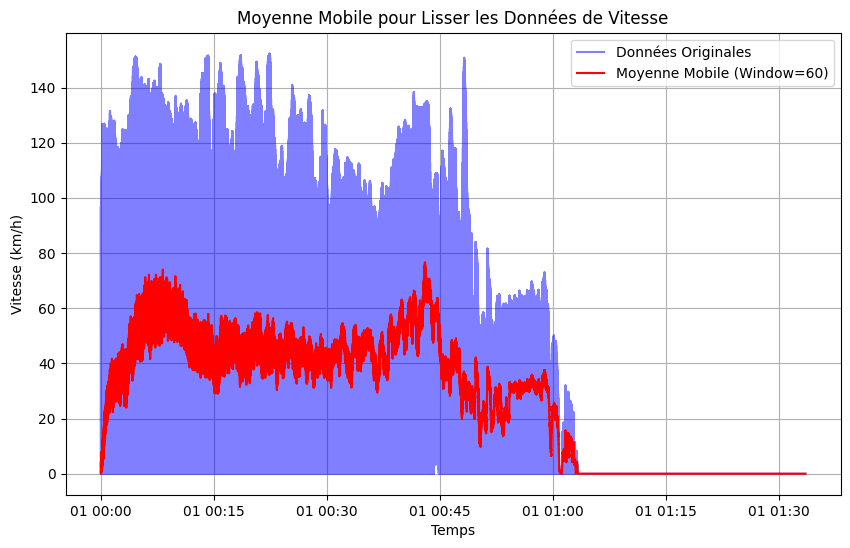

In [56]:
# Convertir la colonne 'time_s' en un objet de date/heure
df['time_s'] = pd.to_datetime(df['time_s'], unit='s')

# Trier les données chronologiquement par rapport au temps
df_sorted = df.sort_values(by='time_s')

# Définir une fenêtre de moyenne mobile
window = 60

# Calculer la moyenne mobile sur la colonne 'velocity_km_h' pour lisser les données
rolling_average_velocity = df_sorted['velocity_km_h'].rolling(window=window).mean()

# Plot des données originales et des données lissées
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['time_s'], df_sorted['velocity_km_h'], label='Données Originales', color='blue', alpha=0.5)
plt.plot(df_sorted['time_s'], rolling_average_velocity, label=f'Moyenne Mobile (Window={window})', color='red')
plt.xlabel('Temps')
plt.ylabel('Vitesse (km/h)')
plt.title('Moyenne Mobile pour Lisser les Données de Vitesse')
plt.legend()
plt.grid(True)
plt.show()